<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Single-qubit Quantum Random Access Coding (QRAC)*_ 
For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Rudy Raymond, Takashi Imamichi

## Introduction

Random Access Coding (RAC) is one of few examples where a small number of quantum bits can exhibit properties that cannot be achieved by the same amount of classical bits. To demonstrate the power of Quantum RAC with a single qubit, consider a case where the sender, say, Alice, wants to encode $n$ bits of information into a qubit. The qubit is then sent to the receiver, say, Bob, who will decode it to obtain one bit (out of $n$ bits sent by Alice) of his choice (which is unknown to Alice). It is known that there is no way for Alice to encode her $2$ bits into one classical bit so that Bob can then recover any bit with success probability better than half. 

On the other hand, with a single qubit it is possible to encode up to $3$ bits of information such that the receiver is quaranteed to observe his choice of bit with probability better than random guessing. The encoding and decoding scheme for encoding 2 bits and 3 bits of information into 1 qubit are denoted as, respectively, $(2,1)$-QRAC and $(3,1)$-QRAC.   

Here, using `QuantumProgram` of IBM Q Experience we describe how to construct the $(2,1)$-QRAC, i.e., encoding $2$ bits of information into $1$ qubit so that any bit can be recovered with probability at least $0.85$, as well as the $(3,1)$-QRAC, i.e., encoding $3$-bits of information into $1$ qubit so that any bit can be recovered with probability at least $0.78$. All necessary unitary gates and measurements can be realized by the $u3$ rotation gates included in the [qelib1.inc](https://github.com/IBM/qiskit-openqasm/blob/master/examples/qelib1.inc) whose mathematical definition can be found [here](https://github.com/IBM/qiskit-openqasm/blob/master/spec/qasm2.pdf).

First, we prepare the environment.

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

sys.path.append("../../")
# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.basicplotter import plot_histogram

## Encoding 2 bits into 1 qubit with $(2,1)$-QRAC
We follow Example 1 described in the paper [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta). Alice encodes her $2$ bits $x_1x_2$ by preparing the following 1-qubit states $|\phi_{x_1x_2}\rangle$.

\begin{eqnarray}
|\phi_{00}\rangle &=& \cos\left(\pi/8\right)|0\rangle + \sin\left(\pi/8\right)|1\rangle\\
|\phi_{10}\rangle &=& \cos\left(3\pi/8\right)|0\rangle + \sin\left(3\pi/8\right)|1\rangle\\
|\phi_{11}\rangle &=& \cos\left(5\pi/8\right)|0\rangle + \sin\left(5\pi/8\right)|1\rangle\\
|\phi_{01}\rangle &=& \cos\left(7\pi/8\right)|0\rangle + \sin\left(7\pi/8\right)|1\rangle\\
\end{eqnarray}

Bob recovers his choice of bit by measuring the qubit in the following way. If he wants to recover the first bit (i.e., $x_1$), he measures the qubit in the $\left\{|0\rangle, |1\rangle\right\}$ basis, namely, he concludes $0$ if he observes $|0\rangle$, and $1$ otherwise. On the other hand, if he wants to recover the second bit (i.e., $x_2$), he measures the qubit in the $\left\{|+\rangle, |-\rangle\right\}$ basis, where $|+\rangle = 1/\sqrt{2}\left(|0\rangle + |1\rangle\right)$, and $|-\rangle = 1/\sqrt{2}\left(|0\rangle - |1\rangle\right)$. 

Below is the code to create quantum circuits for performing experiments of $(2,1)$-QRAC. Each of the circuits consits of encoding $2$ bits of information into $1$ qubit and decoding either the first or the second bit by performing measurement on the qubit. Notice that because in the IBM Q Experience we can only perform measurement in the $\left\{|0\rangle, |1\rangle\right\}$ basis, the measurement in the $\left\{|+\rangle, |-\rangle\right\}$ basis is performed by first applying the Hadamard gate. 

In [2]:
device = 'simulator' # the device to run on
shots = 1024    # the number of shots in the experiment 

#to record the rotation number for encoding 00, 10, 11, 01
rotationNumbers = {"00":1, "10":3, "11":5, "01":7}

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
# qubit for encoding 2 bits of information
qr = Q_program.create_quantum_registers("qr", 1)
# bit for recording the measurement of the qubit
cr = Q_program.create_classical_registers("cr", 1)

# dictionary for encoding circuits
encodingCircuits = {}
# Quantum circuits for encoding 00, 10, 11, 01
for bits in ("00", "01", "10", "11"):
    circuitName = "Encode"+bits
    encodingCircuits[circuitName] = Q_program.create_circuit(circuitName, ["qr"], ["cr"])
    encodingCircuits[circuitName].u3(rotationNumbers[bits]*pi/4.0, 0, 0, qr[0])
    encodingCircuits[circuitName].barrier()

# dictionary for decoding circuits
decodingCircuits = {}
# Quantum circuits for decoding the first and second bit
for pos in ("First", "Second"):
    circuitName = "Decode"+pos
    decodingCircuits[circuitName] = Q_program.create_circuit(circuitName, ["qr"], ["cr"])
    if pos == "Second": #if pos == "First" we can directly measure
        decodingCircuits[circuitName].h(qr[0])
    decodingCircuits[circuitName].measure(qr[0], cr[0])

#combine encoding and decoding of QRACs to get a list of complete circuits
circuitNames = []
for k1 in encodingCircuits.keys():
    for k2 in decodingCircuits.keys():
        circuitNames.append(k1+k2)
        Q_program.add_circuit(k1+k2, encodingCircuits[k1]+decodingCircuits[k2])

print("List of circuit names:", circuitNames) #list of circuit names
#Q_program.get_qasms(circuitNames) #list qasms codes

>> quantum_registers created: qr 1
>> classical_registers created: cr 1
List of circuit names: ['Encode00DecodeFirst', 'Encode00DecodeSecond', 'Encode01DecodeFirst', 'Encode01DecodeSecond', 'Encode10DecodeFirst', 'Encode10DecodeSecond', 'Encode11DecodeFirst', 'Encode11DecodeSecond']


Now, we can perform various experiments of $(2,1)$-QRAC. Below, we execute all circuits of QRACs and plot some experimental results. 

running on backend: simulator
Experimental Result of Encode01DecodeFirst


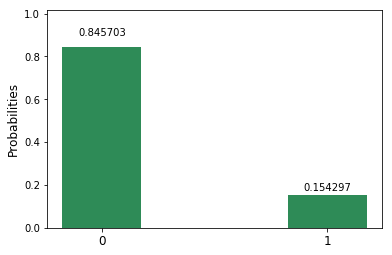

Experimetnal Result of Encode01DecodeSecond


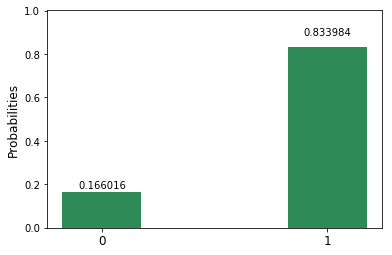

Experimental Result of Encode11DecodeFirst


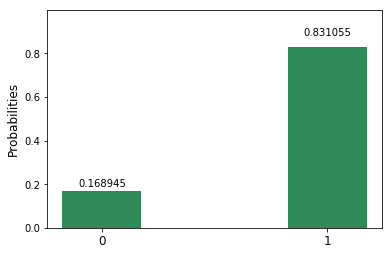

Experimental Result of Encode11DecodeSecond


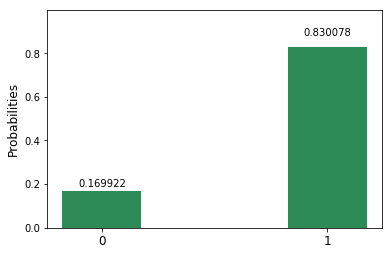

In [3]:
Q_program.execute(circuitNames, device, shots, max_credits=3, wait=10, timeout=240)
print("Experimental Result of Encode01DecodeFirst")
plot_histogram(Q_program.get_counts("Encode01DecodeFirst"))  #We should measure "0" with probability 0.85
print("Experimetnal Result of Encode01DecodeSecond")
plot_histogram(Q_program.get_counts("Encode01DecodeSecond")) #We should measure "1" with probability 0.85
print("Experimental Result of Encode11DecodeFirst")
plot_histogram(Q_program.get_counts("Encode11DecodeFirst"))  #We should measure "1" with probability 0.85
print("Experimental Result of Encode11DecodeSecond")
plot_histogram(Q_program.get_counts("Encode11DecodeSecond")) #We should measure "1" with probability 0.85

From the above simulations, we can see that each of the encoded bits can be decoded with probability closed to the theoretical values. We can now proceed to perform experiments on the real devices or local simulator, as below. 

running on backend: local_qasm_simulator
Experimental Result of Encode01DecodeFirst


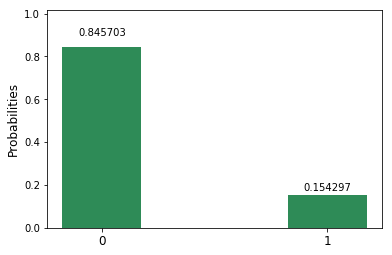

Experimental Result of Encode01DecodeSecond


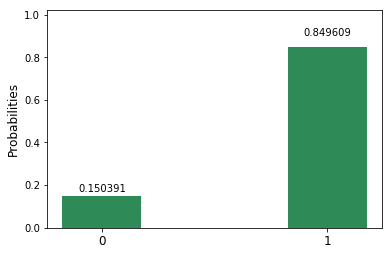

In [4]:
device = "local_qasm_simulator"

Q_program.execute(["Encode01DecodeFirst", "Encode01DecodeSecond"], device, shots, max_credits=3, wait=10, timeout=240)
print("Experimental Result of Encode01DecodeFirst")
plot_histogram(Q_program.get_counts("Encode01DecodeFirst"))  #We should measure "0" with probability 0.85
print("Experimental Result of Encode01DecodeSecond")
plot_histogram(Q_program.get_counts("Encode01DecodeSecond")) #We should measure "1" with probability 0.85

## Encoding 3 bits into 1 qubit with $(3,1)$-QRAC
We follow Example 2 described in the paper [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta). 
Alice encodes her $3$ bits $x_1x_2x_3$ by preparing the following 1-qubit states $|\phi_{x_1x_2x_3}\rangle$ as below, where $\cos^2\left(\theta\right) = 1/2 + \sqrt{3}/6 > 0.788$.   

\begin{eqnarray}
|\phi_{000}\rangle &=& \cos\left(\theta\right)|0\rangle + e^{i\pi/4}\sin\left(\theta\right)|1\rangle\\
|\phi_{001}\rangle &=& \cos\left(\theta\right)|0\rangle + e^{-i\pi/4}\sin\left(\theta\right)|1\rangle\\
|\phi_{010}\rangle &=& \cos\left(\theta\right)|0\rangle + e^{3i\pi/4}\sin\left(\theta\right)|1\rangle\\
|\phi_{011}\rangle &=& \cos\left(\theta\right)|0\rangle + e^{-3i\pi/4}\sin\left(\theta\right)|1\rangle\\
|\phi_{100}\rangle &=& \sin\left(\theta\right)|0\rangle + e^{i\pi/4}\cos\left(\theta\right)|1\rangle\\
|\phi_{101}\rangle &=& \sin\left(\theta\right)|0\rangle + e^{-i\pi/4}\cos\left(\theta\right)|1\rangle\\
|\phi_{110}\rangle &=& \sin\left(\theta\right)|0\rangle + e^{3i\pi/4}\cos\left(\theta\right)|1\rangle\\
|\phi_{111}\rangle &=& \sin\left(\theta\right)|0\rangle + e^{-i\pi/4}\cos\left(\theta\right)|1\rangle\\
\end{eqnarray}

Bob recover his choice of bit by measuring the qubit similarly as in the $(2,1,0.85)$-QRAC for the first and second bit, and to recover the third bit, he measures the qubit in the $\left\{|+'\rangle, |-'\rangle\right\}$ basis, where $|+'\rangle = 1/\sqrt{2}\left(|0\rangle + i |1\rangle\right)$, and $|-'\rangle = 1/\sqrt{2}\left(|0\rangle - i |1\rangle\right)$. 

Intuitively, the encoding of $(3,1)$-QRAC correspond to assigning the $8$ states to the corners of the unit cube inside the Bloch Sphere as depicted in the figure below. 
<img src="../images/blochsphere31.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="300 px" align="center">

Below is the code to create quantum circuits for performing experiments of $(3,1)$-QRAC. Similarly to the $(2,1)$-QRAC, each of the circuits consists of encoding $3$ bits of information into $1$ qubit and decoding either the first, the second, or the third bit by performing measurement on the qubit.

In [5]:
device = 'simulator' # the device to run on
shots = 1024    # the number of shots in the experiment 
from math import sqrt, cos, acos

#compute the value of theta
theta = acos(sqrt(0.5 + sqrt(3.0)/6.0))

#to record the u3 parameters for encoding 000, 010, 100, 110, 001, 011, 101, 111
rotationParams = {"000":(2*theta, pi/4, -pi/4), "010":(2*theta, 3*pi/4, -3*pi/4), 
                  "100":(pi-2*theta, pi/4, -pi/4), "110":(pi-2*theta, 3*pi/4, -3*pi/4), 
                  "001":(2*theta, -pi/4, pi/4), "011":(2*theta, -3*pi/4, 3*pi/4), 
                  "101":(pi-2*theta, -pi/4, pi/4), "111":(pi-2*theta, -3*pi/4, 3*pi/4)}

Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
# qubit for encoding 3 bits of information
qr = Q_program.create_quantum_registers("qr", 1)
# bit for recording the measurement of the qubit
cr = Q_program.create_classical_registers("cr", 1)

# dictionary for encoding circuits
encodingCircuits = {}
# Quantum circuits for encoding 000, ..., 111
for bits in rotationParams.keys():
    circuitName = "Encode"+bits
    encodingCircuits[circuitName] = Q_program.create_circuit(circuitName, ["qr"], ["cr"])
    encodingCircuits[circuitName].u3(*rotationParams[bits], qr[0])
    encodingCircuits[circuitName].barrier()

# dictionary for decoding circuits
decodingCircuits = {}
# Quantum circuits for decoding the first, second and third bit
for pos in ("First", "Second", "Third"):
    circuitName = "Decode"+pos
    decodingCircuits[circuitName] = Q_program.create_circuit(circuitName, ["qr"], ["cr"])
    if pos == "Second": #if pos == "First" we can directly measure
        decodingCircuits[circuitName].h(qr[0])
    elif pos == "Third":
        decodingCircuits[circuitName].u3(pi/2, -pi/2, pi/2, qr[0])
    decodingCircuits[circuitName].measure(qr[0], cr[0])

#combine encoding and decoding of QRACs to get a list of complete circuits
circuitNames = []
for k1 in encodingCircuits.keys():
    for k2 in decodingCircuits.keys():
        circuitNames.append(k1+k2)
        Q_program.add_circuit(k1+k2, encodingCircuits[k1]+decodingCircuits[k2])

print("List of circuit names:", circuitNames) #list of circuit names
#Q_program.get_qasms(circuitNames) #list qasms codes

>> quantum_registers created: qr 1
>> classical_registers created: cr 1
List of circuit names: ['Encode000DecodeFirst', 'Encode000DecodeSecond', 'Encode000DecodeThird', 'Encode010DecodeFirst', 'Encode010DecodeSecond', 'Encode010DecodeThird', 'Encode100DecodeFirst', 'Encode100DecodeSecond', 'Encode100DecodeThird', 'Encode110DecodeFirst', 'Encode110DecodeSecond', 'Encode110DecodeThird', 'Encode001DecodeFirst', 'Encode001DecodeSecond', 'Encode001DecodeThird', 'Encode011DecodeFirst', 'Encode011DecodeSecond', 'Encode011DecodeThird', 'Encode101DecodeFirst', 'Encode101DecodeSecond', 'Encode101DecodeThird', 'Encode111DecodeFirst', 'Encode111DecodeSecond', 'Encode111DecodeThird']


Now, we can perform various experiments of $(3,1)$-QRAC. Below, we execute all circuits of QRACs and plot some experimental results. 

running on backend: simulator
Experimental Result of Encode010DecodeFirst


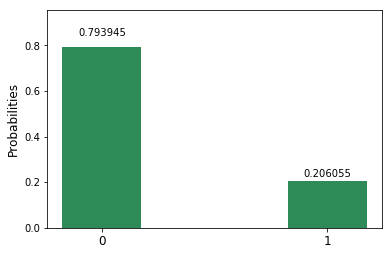

Experimental Result of Encode010DecodeSecond


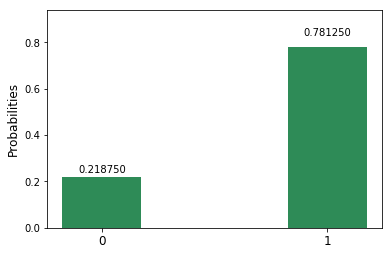

Experimental Result of Encode010DecodeThird


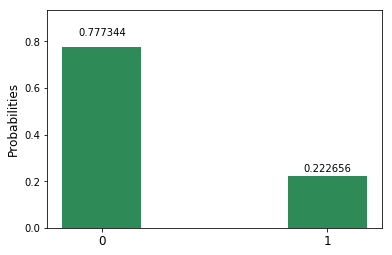

In [6]:
Q_program.execute(circuitNames, device, shots, max_credits=3, wait=10, timeout=240)
print("Experimental Result of Encode010DecodeFirst")
plot_histogram(Q_program.get_counts("Encode010DecodeFirst"))  #We should measure "0" with probability 0.78
print("Experimental Result of Encode010DecodeSecond")
plot_histogram(Q_program.get_counts("Encode010DecodeSecond")) #We should measure "1" with probability 0.78
print("Experimental Result of Encode010DecodeThird")
plot_histogram(Q_program.get_counts("Encode010DecodeThird"))  #We should measure "0" with probability 0.78

Now, we can perform various experiments of $(3,1)$-QRAC. Below, we execute all circuits of QRACs and plot some experimental results. 

running on backend: local_qasm_simulator
Experimental Result of Encode010DecodeFirst


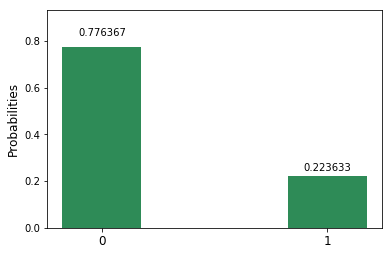

Experimental Result of Encode010DecodeSecond


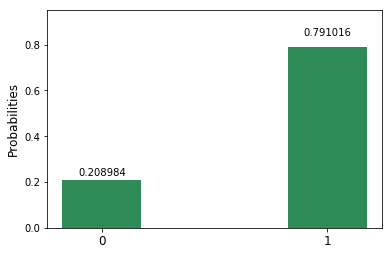

Experimental Result of Encode010DecodeThird


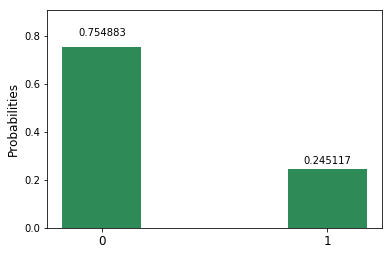

In [7]:
device = "local_qasm_simulator"
Q_program.execute(["Encode010DecodeFirst", "Encode010DecodeSecond", "Encode010DecodeThird"], device, shots, max_credits=3, wait=10, timeout=240)
print("Experimental Result of Encode010DecodeFirst")
plot_histogram(Q_program.get_counts("Encode010DecodeFirst"))  #We should measure "0" with probability 0.78
print("Experimental Result of Encode010DecodeSecond")
plot_histogram(Q_program.get_counts("Encode010DecodeSecond")) #We should measure "1" with probability 0.78
print("Experimental Result of Encode010DecodeThird")
plot_histogram(Q_program.get_counts("Encode010DecodeThird"))  #We should measure "0" with probability 0.78

## About Quantum Random Access Coding
The notion of Quantum RAC was first presented [here](https://arxiv.org/abs/quant-ph/9804043) along with the concrete example of $(2,1)$-QRAC which apparently was discovered much earlier in 1983 by [Wiesner](http://dl.acm.org/citation.cfm?doid=1008908.1008920). The idea of the $(3,1)$-QRAC appeared in the [classic book of Mike and Ike](https://www.amazon.com/Quantum-Computation-Information-10th-Anniversary/dp/1107002176). The first experiments on $(2,1)$-QRAC and $(3,1)$-QRAC were presented [here](https://arxiv.org/abs/0805.1463). It is not possible to perform $(4,1)$-QRAC as shown [here](http://iopscience.iop.org/article/10.1088/1367-2630/8/8/129/meta).  